In [1]:
import smo
from kernels import Kernel
import numpy as np
import pandas as pd
import math
import random
import itertools
from tqdm import tqdm
from enum import Enum, auto
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
def kernel_params(kernel):
    result = {
        Kernel.linear: [1],
        Kernel.polynomial: [2, 3, 4, 5],
        Kernel.gauss: [1, 2, 3, 4, 5]
    }[kernel]
    return result

def c_param():
    return [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]

def all_kernels():
    return [Kernel.linear, Kernel.polynomial, Kernel.gauss]

def all_params_combinations(kernel: Kernel):
    return itertools.product(kernel_params(kernel), c_param()) 

In [3]:
chips_dataset = pd.read_csv('chips.csv')
geyser_dataset = pd.read_csv('geyser.csv') 

In [4]:
chips_dataset

,x,y,class
0,0.051267,0.699560,P
1,-0.092742,0.684940,P
2,-0.213710,0.692250,P
3,-0.375000,0.502190,P
4,-0.513250,0.465640,P
...,...,...,...
113,-0.720620,0.538740,N
114,-0.593890,0.494880,N
115,-0.484450,0.999270,N
116,-0.006336,0.999270,N


In [5]:
geyser_dataset

,x,y,class
0,1,4.4,N
1,1,3.9,N
2,1,4.0,P
3,1,4.0,N
4,1,3.5,N
...,...,...,...
217,23,2.1,P
218,23,4.2,N
219,23,2.1,P
220,23,5.2,N


In [6]:
def class_to_int(ch):
    if (ch =='P'):
        return 1
    else:
        return -1

def dataset_to_local(dataset):
    rows = dataset.values.tolist()
    random.shuffle(rows)
    xs, ys = [], []
    for row in rows:
        clazz = row.pop()
        y = class_to_int(clazz)
        x = row
        xs.append(x)
        ys.append(y)
    return xs, ys

In [7]:
def split_in_chunks(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0
    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg
    return out


def train_test(chunks, test_idx):
    train = []
    test = []
    for i in range(len(chunks)):
        if i != test_idx:
            train.extend(chunks[i])
        else:
            test.extend(chunks[i])
    return train, test     


def train_test_blocks(xs, ys, k):
    xs_chunks = split_in_chunks(xs, k)
    ys_chunks = split_in_chunks(ys, k)
    xs_train_test = []
    ys_train_test = []
    assert(len(xs_chunks) == len(ys_chunks))
    assert(len(xs_chunks) == k)
    for i in range(k):
        xs_train_test.append(train_test(xs_chunks, i))
        ys_train_test.append(train_test(ys_chunks, i))
    return xs_train_test, ys_train_test


In [19]:
def draw(model, x_, y_, sc_x):
    x = np.array(x_)
    y = np.array(y_)
    sc_y = 0.01
    x_min, y_min = np.amin(x, 0)
    x_max, y_max = np.amax(x, 0)
    x_min =  x_min - sc_x
    x_max = x_max + sc_x
    y_min = y_min - sc_y
    y_max = y_max + sc_y
    xx, yy = np.meshgrid(np.arange(x_min, x_max, sc_x), np.arange(y_min, y_max, sc_y))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = np.apply_along_axis(lambda t: model.predict(t), 1, grid)
    zz = np.array(zz).reshape(xx.shape)
    
    plt.figure(figsize=(10, 10))
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    x_neg, y_neg = x[y == -1].T
    x_pos, y_pos = x[y == 1].T
    
    plt.pcolormesh(xx, yy, zz, shading='nearest', cmap=ListedColormap(['#F54281', '#03A5FC']))
    plt.scatter(x_neg, y_neg, color='red', s=100)
    plt.scatter(x_pos, y_pos, color='blue', s=100)
    
    plt.show()

In [9]:
def handle_dataset_with_kernel(xs, ys, kernel: Kernel):
    params = all_params_combinations(kernel)
    best_model = smo.SVMModel(0, 0, [], [], Kernel.linear, 0)
    best_accuracy = 0
    for p, c in tqdm(params):
        xs_train_test, ys_train_test = train_test_blocks(xs, ys, 3)
        assert(len(xs_train_test) == len(ys_train_test))
        accuracy = 0
        for i in range(len(list(zip(xs_train_test, ys_train_test)))):
            xs_train, xs_test = xs_train_test[i]
            ys_train, ys_test = ys_train_test[i]
            model = smo.simplified_SMO(xs_train, ys_train, c, kernel, p)
            for x_test, y_test in zip(xs_test, ys_test):
                val = model.predict(x_test)
                if val == y_test:
                    accuracy += 1
        accuracy /= float(len(ys))
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
    return best_model, best_accuracy

In [10]:
xs_chips, ys_chips = dataset_to_local(chips_dataset)
xs_geyeser, ys_geyeser = dataset_to_local(geyser_dataset)

8it [00:28,  3.60s/it]


Best accuracy: 0.4915254237288136, c: 1.0


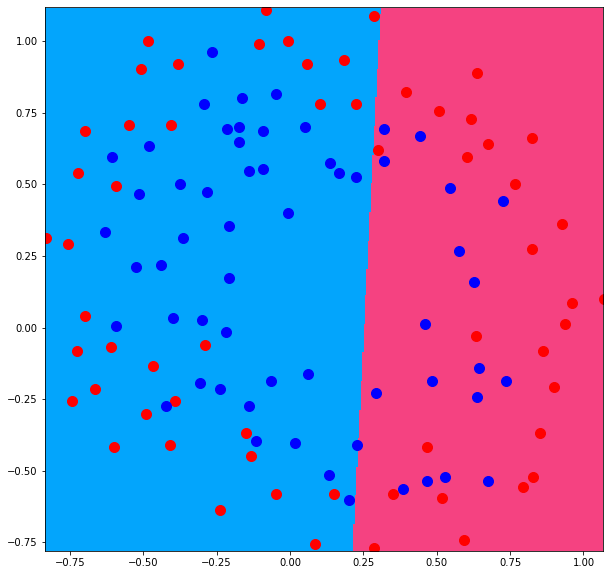

In [11]:
model_c_l, accuracy_c_l = handle_dataset_with_kernel(xs_chips, ys_chips, Kernel.linear)
print(f'Best accuracy: {accuracy_c_l}, c: {model_c_l.c}')
draw(model_c_l, xs_chips, ys_chips, 0.005)

32it [02:10,  4.09s/it]


Best accuracy: 0.7627118644067796, c: 1.0, p: 2


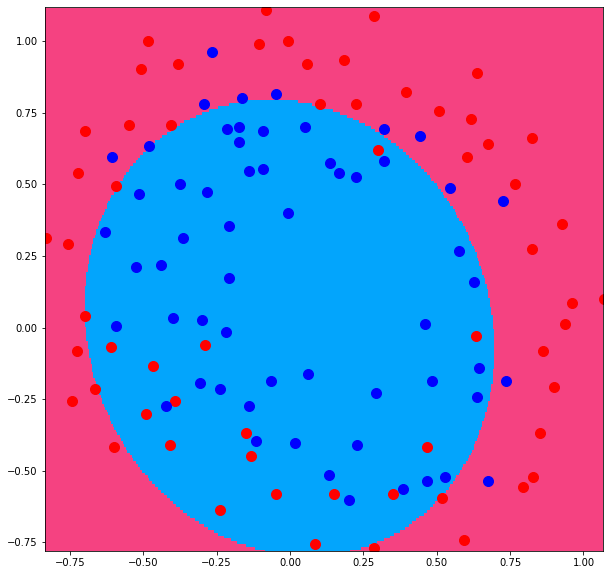

In [12]:
model_c_p, accuracy_c_p = handle_dataset_with_kernel(xs_chips, ys_chips, Kernel.polynomial)
print(f'Best accuracy: {accuracy_c_p}, c: {model_c_p.c}, p: {model_c_p.param}')
draw(model_c_p, xs_chips, ys_chips, 0.005)

40it [03:07,  4.69s/it]


Best accuracy: 0.8389830508474576, c: 10.0, betta: 1


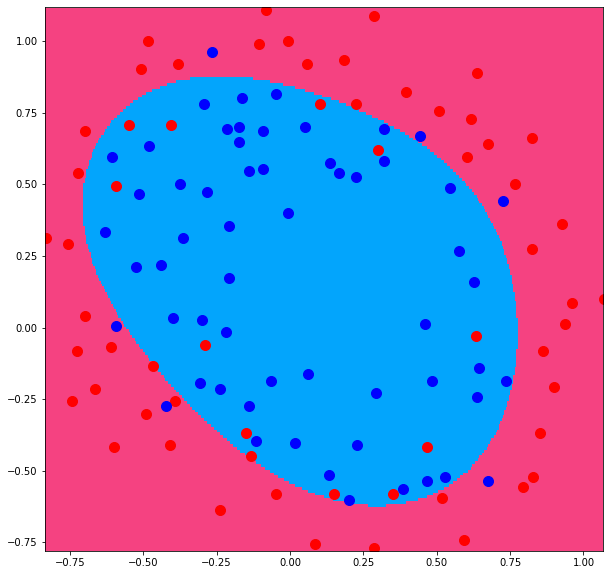

In [13]:
model_c_g, accuracy_c_g = handle_dataset_with_kernel(xs_chips, ys_chips, Kernel.gauss)
print(f'Best accuracy: {accuracy_c_g}, c: {model_c_g.c}, betta: {model_c_g.param}')
draw(model_c_g, xs_chips, ys_chips, 0.005)

8it [01:13,  9.24s/it]


Best accuracy: 0.9099099099099099, c: 1.0


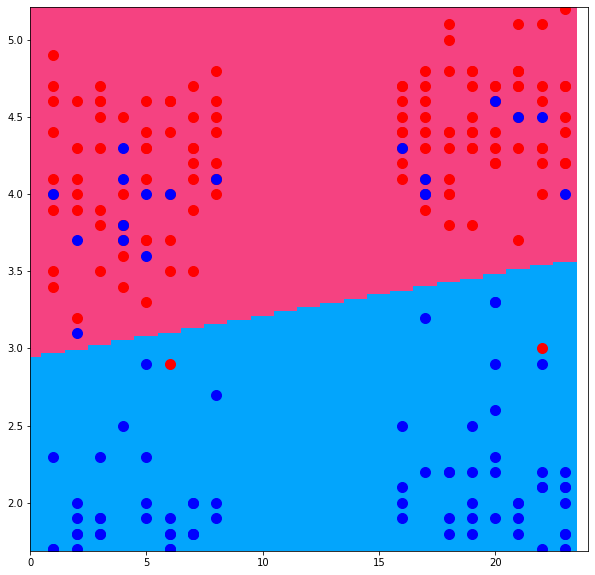

In [20]:
model_g_l, accuracy_g_l = handle_dataset_with_kernel(xs_geyeser, ys_geyeser, Kernel.linear)
print(f'Best accuracy: {accuracy_g_l}, c: {model_g_l.c}')
draw(model_g_l, xs_geyeser, ys_geyeser, 1)

32it [06:41, 12.55s/it]


Best accuracy: 0.8918918918918919, c: 0.1, p: 2


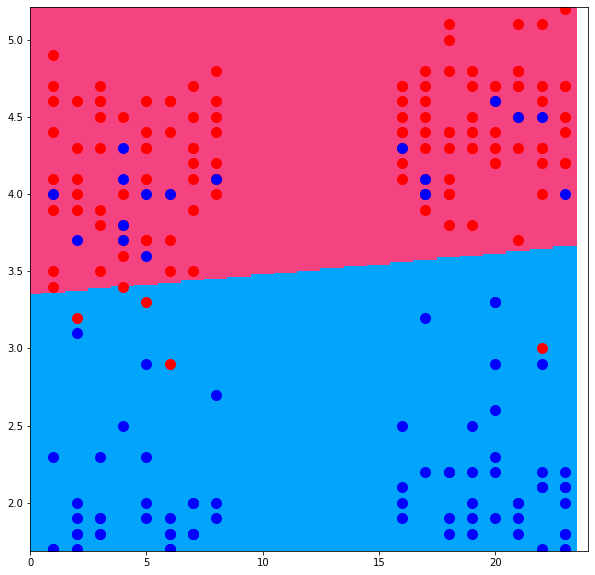

In [21]:
model_g_p, accuracy_g_p = handle_dataset_with_kernel(xs_geyeser, ys_geyeser, Kernel.polynomial)
print(f'Best accuracy: {accuracy_g_p}, c: {model_g_p.c}, p: {model_g_p.param}')
draw(model_g_p, xs_geyeser, ys_geyeser, 1)

40it [07:51, 11.79s/it]


Best accuracy: 0.8963963963963963, c: 0.5, betta: 1


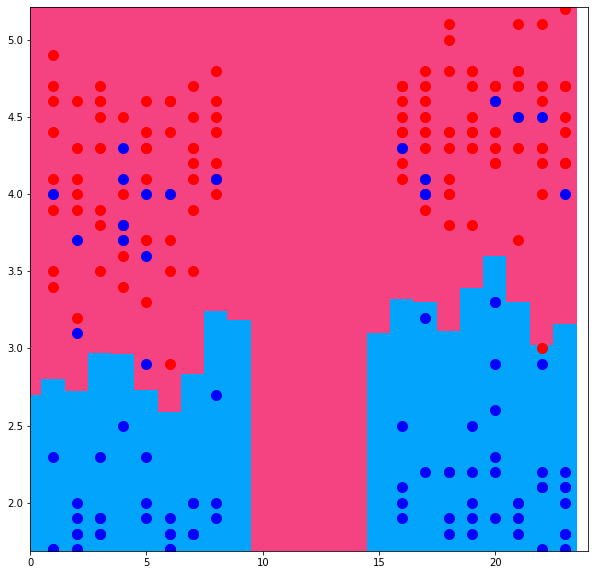

In [22]:
model_g_g, accuracy_g_g = handle_dataset_with_kernel(xs_geyeser, ys_geyeser, Kernel.gauss)
print(f'Best accuracy: {accuracy_g_g}, c: {model_g_g.c}, betta: {model_g_g.param}')
draw(model_g_g, xs_geyeser, ys_geyeser, 1)